# Equity Convexity 
https://medium.com/@yuhui_w/equity-convexity-and-asset-pricing-in-different-volatility-regimes-4f9d8a2081d2


## Introduction
The traditional CAPM equation:
$$ r_{asset} = r_{risk \ free} + \beta (r_{market} - r_{risk \ free}) $$

The CAPM equation with convexity adjustment:
$$ r_{asset} = r_{risk \ free} + \beta (r_{market} - r_{risk \ free}) + \gamma (r_{market} - r_{risk \ free})^2 $$

where:   
$\alpha$ is the intercept,  
$\beta$ is the slope,    
$\gamma$ is the convexity,   
and $r_{market}$ is the market risk-free rate.  

if we assume a zero risk free rate and zero expected return for the market portfolio, then the term $r_{market} - r_{risk \ free}^2$ is the variance of the market returns.

This model has some interesting properties and applications, but in general:  
1. We want to invest in assests that has a positive gamma due to upside coupling and downside decoupling. 
2. We can use conditional volatility to estimate the expected return of an asset.
3. The convex relationship yields a marginally higher r squared value and lower sum of squares than the traditional CAPM equation.
4. This relationship can be used to formulate a hedging or statistical arbitrage program.
5. In corprate finance, to determine the cost of equity financing and cost of debt financing. (comparing cost and return to filter the assets to invest in)

**For the purpose of this notebook, we will use the following assumptions:**
1. The market risk-free rate is zero.
2. Weekly data is used estimated the model 

**Flow:** 
1. Load data.
2. Comparison between CAPM and Convex model 
3. Convexity Model under different volatility regimes (Hidden Markov Model & Markov Switching Autoregressive model)
4. Convexity Model under different macroeconomic regime (Gaussian Mixture Model ref. 2sigma n t-ball finance)
5. Abnormal returns under different regimes,

## 1. Data

In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics

import yfinance as yf

In [335]:
benchmark = '^GSPC'
asset = 'AAL'
rf = '^TNX'  

tickers = benchmark + ' ' + asset + ' ' + rf

data = yf.download(tickers, period='20y', interval='1wk')[['Adj Close']].ffill().dropna()
data.index = pd.to_datetime(data.index)
data.columns = data.columns.droplevel()

data.head()

[*********************100%***********************]  3 of 3 completed


,AAL,^GSPC,^TNX
Date,,,
2005-09-26,19.807001,1228.810059,4.328
2005-10-03,20.881720,1195.900024,4.361
2005-10-10,20.994852,1186.569946,4.491
2005-10-17,20.702600,1179.589966,4.390
2005-10-24,22.531519,1198.410034,4.567


In [336]:
log_returns = pd.DataFrame(index=data.index, columns=data.columns)
log_returns[benchmark] = np.log(data[benchmark] / data[benchmark].shift(1))
log_returns[asset] = np.log(data[asset] / data[asset].shift(1))

log_returns[rf] = data[rf] / 100 / 52
log_returns[benchmark] = log_returns[benchmark] - log_returns[rf]
log_returns.replace([np.inf, -np.inf, np.PZERO], np.nan, inplace=True)
log_returns.dropna(inplace=True)

log_returns.head()

,AAL,^GSPC,^TNX
Date,,,
2005-10-03,0.052839,-0.027986,0.000839
2005-10-10,0.005403,-0.008696,0.000864
2005-10-17,-0.014018,-0.006744,0.000844
2005-10-24,0.084656,0.014951,0.000878
2005-10-31,0.186497,0.017074,0.000896


In [337]:
def data_stats(data):
    """
    Calculate descriptive statistics for a dataframe
    """
    stats = pd.DataFrame(data.describe()).T
    stats.columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    skewness = data.skew()
    kurtosis = data.kurtosis()
    stats['skewness'] = skewness
    stats['kurtosis'] = kurtosis

    stats = stats.T

    print(stats)

    sns.histplot(data, bins=50)

## 2. CAPM vs Convex Model

In [338]:
# capm and convex model
class capm:

    '''''''''''''''''''''
    input:
    data - pandas dataframe with returns of asset and benchmark
    asset - string with ticker of asset
    benchmark - string with ticker of benchmark
    rf - risk free rate
    orde - order of polynomial regression
    
    output:
    alpha - float with asset alpha
    beta - float with asset beta
    gamma - float with asset gamma
    r_squared - float with r squared
    root_mean_squared_error - float with root mean squared error
    regression plot
    '''''''''''''''''''''


    def __init__(self, dataframe, asset, benchmark, rf, order):

        from distutils.log import warn

        self.data = dataframe
        self.x = self.data[benchmark]
        self.y = self.data[asset]
        self.rf = rf
        self.order = order

        if self.order > 2 or self.order < 1:
            warn('ORDER MUST BE 1 OR 2') 



    def mean_test(self, alpha = 0.05):

        from scipy.stats import ttest_1samp

        self.test = ttest_1samp(self.y, 0)




    def fit(self):
        self.model = np.polyfit(self.x, self.y, self.order)
        
        self.mean_test()

        if self.test.pvalue > 0.05:
            pass
        else:
            from distutils.log import warn
            warn('H0 is false, the Mean of the distribution is not zero, the model may not valid')



    def params(self):

        if self.order == 1:
            self.beta, self.alpha = self.model
            self.gamma = 0
        else:
            self.gamma, self.beta, self.alpha = self.model

        return self.alpha, self.beta, self.gamma



    def metrics(self, verbose = False):
        from scipy.stats import linregress

        if verbose == False:
            alpha, beta, gamma = self.params()
            
            self.r_squared = metrics.r2_score(self.y, (alpha + beta * self.x + gamma * self.x ** 2))
            self.root_mean_squared_error = np.sqrt(metrics.mean_squared_error(self.y, (alpha + beta * self.x + gamma * self.x ** 2)))

            print(f'alpha: {self.alpha}')
            print(f'beta: {self.beta}')
            print(f'gamma: {self.gamma}')
            print(f'r_squared: {self.r_squared}')
            print(f'root_mean_squared_error: {self.root_mean_squared_error}')
        else:
            print(linregress(self.x, self.y))
            print(linregress(self.x**2, self.y))



    def plot(self, add_convex = False):
        import warnings
        warnings.filterwarnings("ignore")

        if add_convex == False:
            plt.subplots(figsize=(12,8))
            plot = sns.regplot(self.data[benchmark], self.data[asset], data=self.data, scatter=True, label='data', order=1)
        else:
            plt.subplots(figsize=(12,8))
            plot = sns.regplot(self.data[benchmark], self.data[asset], data=self.data, scatter=True, label='data', order=2)
            plot_capm = sns.regplot(self.data[benchmark], self.data[asset], data=self.data, scatter=True, label='data', order=1)



    def expected_returns(self, variance = None):

        if variance == None:
            self.variance = self.x.var()
            return self.rf + self.beta * self.x + self.gamma * self.variance
        else:
            return self.rf + self.beta * self.x + self.gamma * self.variance

alpha: -0.002067363042375144
beta: 1.9195485593610848
gamma: 0
r_squared: 0.2556101364109695
root_mean_squared_error: 0.08305578672769412


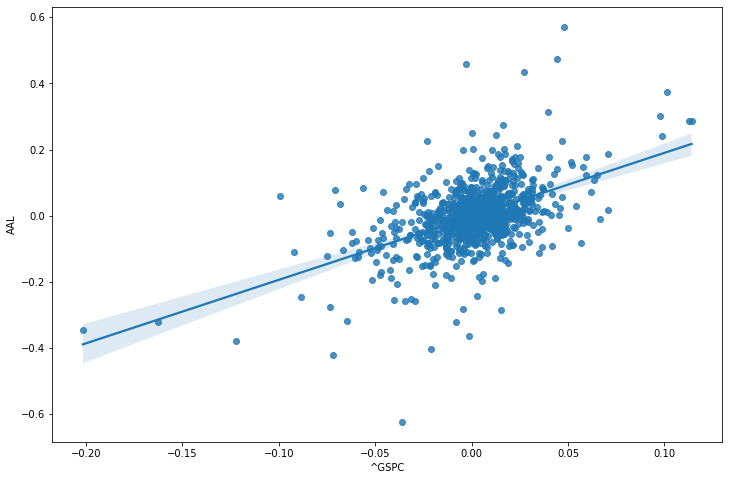

In [339]:
m = capm(log_returns, asset, benchmark, rf, 1)
m.fit()
m.metrics()
m.plot(add_convex = False)

alpha: -0.0034117345309321156
beta: 1.9674811192233304
gamma: 2.0247104736307957
r_squared: 0.25738900296194367
root_mean_squared_error: 0.08295648826845456


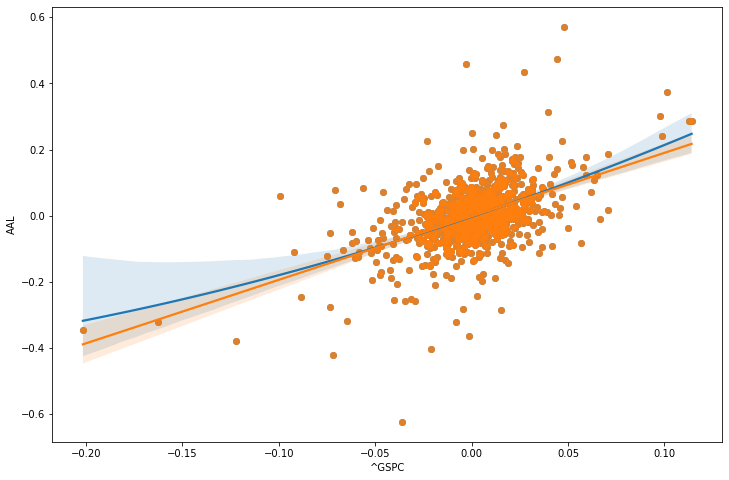

In [340]:
m = capm(log_returns, asset, benchmark, rf, 2)
m.fit()
m.metrics()
m.plot(add_convex = True)

## 3. Convexity Model under different volatility regimes

This section will focus on assesing the convex model in different volatility regimes of the benchmark.   

Steps:     
1. Run GARCH model on the benchmark.
2. Run HMM and MSAR model on the benchmark.
3. Split the data based on the regime.
4. Run the convex model on different regimes.

Iteration:      1,   Func. Count:      8,   Neg. LLF: 48439.12461727587
Iteration:      2,   Func. Count:     18,   Neg. LLF: 66891.59863084195
Iteration:      3,   Func. Count:     27,   Neg. LLF: 21403.035119866705
Iteration:      4,   Func. Count:     35,   Neg. LLF: 19625.954166264873
Iteration:      5,   Func. Count:     43,   Neg. LLF: 1919.62716286587
Iteration:      6,   Func. Count:     51,   Neg. LLF: 1880.5979618905483
Iteration:      7,   Func. Count:     59,   Neg. LLF: 1882.0566217988521
Iteration:      8,   Func. Count:     67,   Neg. LLF: 1858.1938085086556
Iteration:      9,   Func. Count:     75,   Neg. LLF: 1857.3454356724765
Iteration:     10,   Func. Count:     83,   Neg. LLF: 1856.954017519428
Iteration:     11,   Func. Count:     90,   Neg. LLF: 1856.9385991437332
Iteration:     12,   Func. Count:     97,   Neg. LLF: 1856.9384273818441
Iteration:     13,   Func. Count:    104,   Neg. LLF: 1856.9384120340696
Iteration:     14,   Func. Count:    110,   Neg. LLF: 18

<AxesSubplot:xlabel='Date'>

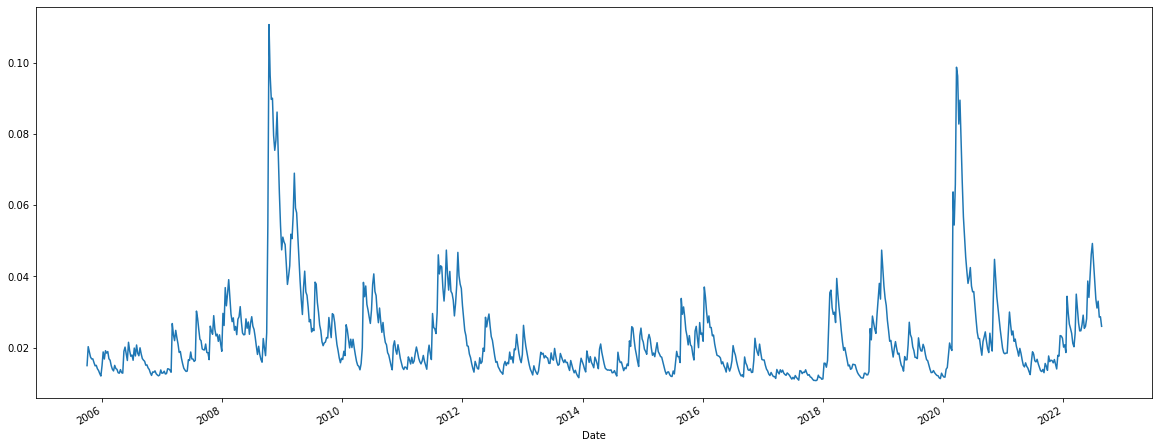

In [341]:
import arch 

am = arch.univariate.arch_model(log_returns[benchmark], x=None, 
                                mean='HARX', lags=0, 
                                vol='Garch', p=1, o=0, q=1, 
                                dist='skewt', hold_back=None, rescale=True)

volatility_model = am.fit()
volatility_model.summary()
plt.subplots(figsize=(20,8))
garch_vol = volatility_model.conditional_volatility/100
garch_vol.plot(label='garch volatility')

<AxesSubplot:xlabel='Date'>

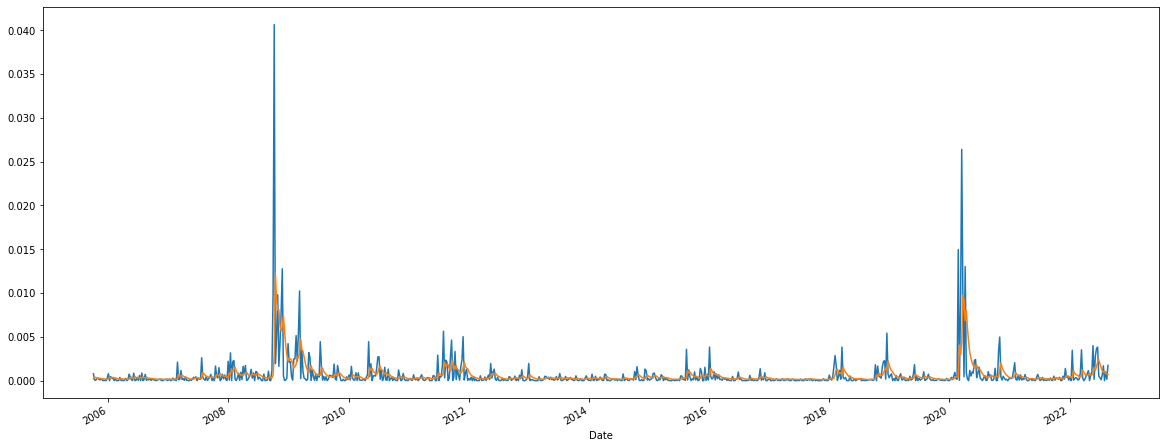

In [342]:
(log_returns[benchmark]**2).plot(figsize=(20,8), label='benchmark squared returns')
(garch_vol**2).plot(label='garch volatility squared')

In [343]:
def fitHMM(vol, n_states):
    from hmmlearn.hmm import GaussianHMM
    
    train_vals = np.expand_dims(vol, 1)
    
    train_vals = np.reshape(train_vals,[len(vol),1])
    
    # fit Gaussian HMM to Q
    model = GaussianHMM(n_components=n_states, n_iter=100).fit(train_vals)
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(train_vals)
    post_prob = np.array(model.predict_proba(train_vals))
 
    # fit HMM parameters
    mus = np.squeeze(model.means_)
    sigmas = np.squeeze(np.sqrt(model.covars_))
    transmat = np.array(model.transmat_)
    print(mus)
    print(sigmas)
    
    relabeled_states = hidden_states
    
    return (relabeled_states, mus, sigmas, transmat, post_prob, model)

In [344]:
def plot_model(dates, vol, post_prob, export_label):
    
    import plotly.graph_objects as go

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=dates, y=vol, name="GARCH", mode='lines', line_shape='hv', yaxis = 'y1'))

    fig.add_trace(go.Scatter(x=dates, y=post_prob.iloc[:,0], name = 'Pr(Low Vol Regime)', mode='lines', line_shape='hv',
                             line=dict(width=0.5, color='green'), 
                             stackgroup='two', yaxis = 'y2'))

    fig.add_trace(go.Scatter(x=dates, y=post_prob.iloc[:,1], name = 'Pr(Medium Vol Regime)', mode='lines', line_shape='hv',
                             line=dict(width=0.5, color='orange'),
                             stackgroup='two', yaxis = 'y2'))

    fig.add_trace(go.Scatter(x=dates, y=post_prob.iloc[:,2], name = 'Pr(High Vol Regime)', mode='lines', line_shape='hv',
                             line=dict(width=0.5, color='red'),
                             stackgroup='two', yaxis = 'y2'))

    # Create axis objects
    fig.update_layout(
        title = ("Volatility Regime - " + str(export_label)),

        yaxis=dict(title="Volatility"),

        yaxis2=dict(title="Posterier Probability", overlaying="y1", side="right")

    ) 

    fig.show()

In [345]:
hidden_states, mus, sigmas, transmat, post_prob, hmm_model = fitHMM(garch_vol, 3)
dates = garch_vol.index

hmm_data = pd.DataFrame([dates, garch_vol, hidden_states], 
                        index = ["date", "volatility", "hidden_states"]).T

hmm_prob = pd.DataFrame(post_prob, columns = ['state_1', 'state_2', 'state_3'])
hmm_data = pd.concat([hmm_data, hmm_prob], axis=1)

hmm_data.date = pd.to_datetime(hmm_data.date)
hmm_data = hmm_data.sort_values(by="date")
hmm_data.index = hmm_data.date

hmm_data

[0.03044411 0.01680682 0.06511362]
[0.00948148 0.00544137 0.02474448]


,date,volatility,hidden_states,state_1,state_2,state_3
date,,,,,,
2005-10-03,2005-10-03,0.014955,1,1.200297e-34,1.000000,6.041884e-97
2005-10-10,2005-10-10,0.020272,1,5.371620e-04,0.999463,1.908723e-07
2005-10-17,2005-10-17,0.018787,1,5.068285e-04,0.999493,1.190217e-07
2005-10-24,2005-10-24,0.017366,1,3.857702e-04,0.999614,9.101987e-08
2005-10-31,2005-10-31,0.016829,1,3.306198e-04,0.999669,8.373777e-08
...,...,...,...,...,...,...
2022-07-25,2022-07-25,0.031107,0,9.999366e-01,0.000063,3.282386e-08
2022-08-01,2022-08-01,0.033041,0,9.999519e-01,0.000048,1.293924e-07
2022-08-08,2022-08-08,0.028554,0,9.989467e-01,0.001053,6.525634e-08


In [346]:
plot_model(hmm_data.date, hmm_data.volatility, hmm_prob, 'HMM')

In [347]:
# spliting returns data into acording to hidden states
state_0 = log_returns.loc[hmm_data[hmm_data.hidden_states == 0].index]
state_1 = log_returns.loc[hmm_data[hmm_data.hidden_states == 1].index]
state_2 = log_returns.loc[hmm_data[hmm_data.hidden_states == 2].index]

alpha: -0.01666202970765862
beta: 1.834766542534855
gamma: 8.740578086110308
r_squared: 0.2292634776420871
root_mean_squared_error: 0.10013572687864647


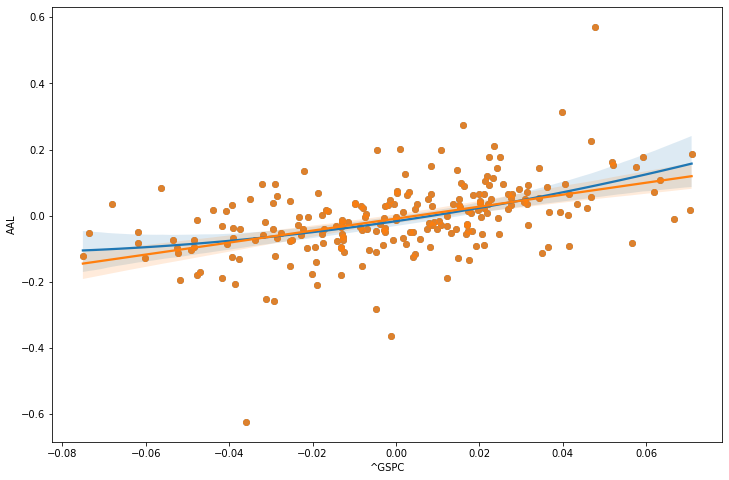

In [348]:
# fit convex CAPM model to each state
s0_convex = capm(state_0, asset, benchmark, rf, 2)
s0_convex.fit()
s0_convex.metrics()
s0_convex.plot(add_convex=True)


                 AAL       ^GSPC        ^TNX
count     223.000000  223.000000  223.000000
mean       -0.008621    0.000188    0.000529
std         0.114317    0.029740    0.000171
min        -0.623813   -0.075095    0.000103
25%        -0.072783   -0.019789    0.000409
50%        -0.012021    0.001580    0.000552
75%         0.050289    0.020828    0.000661
max         0.571249    0.070892    0.000844
skewness   -0.105054   -0.109501   -0.580408
kurtosis    6.181726   -0.305125   -0.027054


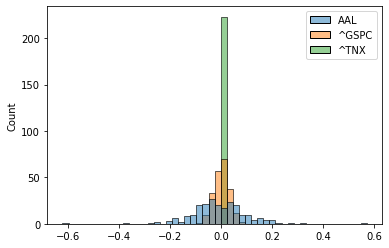

In [349]:
data_stats(state_0)

alpha: 0.003100488906586625
beta: 1.5299322193138403
gamma: -2.9599667008370574
r_squared: 0.1420652474259344
root_mean_squared_error: 0.06695388679472494


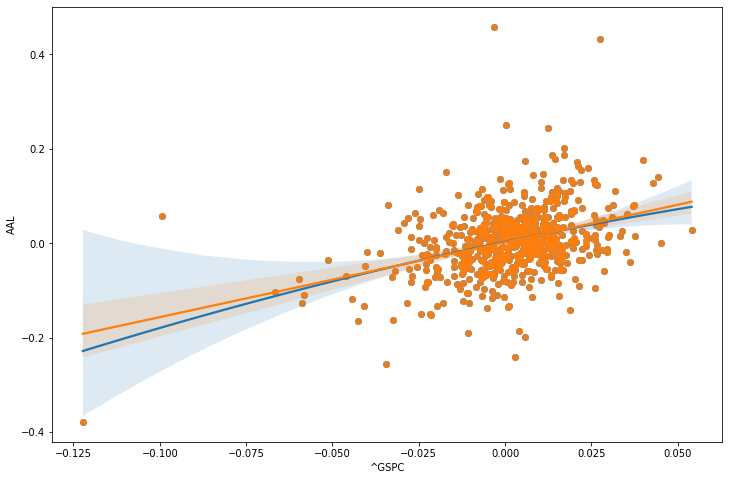

In [350]:
s1_convex = capm(state_1, asset, benchmark, rf, 2)
s1_convex.fit()
s1_convex.metrics()
s1_convex.plot(add_convex=True)

                 AAL       ^GSPC        ^TNX
count     620.000000  620.000000  620.000000
mean        0.004728    0.001635    0.000516
std         0.072343    0.017126    0.000219
min        -0.378688   -0.122279    0.000108
25%        -0.035652   -0.006574    0.000348
50%         0.004622    0.002446    0.000462
75%         0.040838    0.012057    0.000641
max         0.458615    0.054013    0.001005
skewness    0.496299   -1.310630    0.720338
kurtosis    5.763492    6.773364   -0.502653


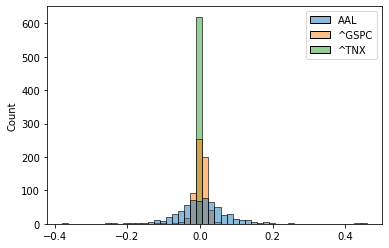

In [351]:
data_stats(state_1)

alpha: -0.045099324468873186
beta: 2.559721749421808
gamma: 5.872505411600309
r_squared: 0.5456337883696831
root_mean_squared_error: 0.15244021905303312


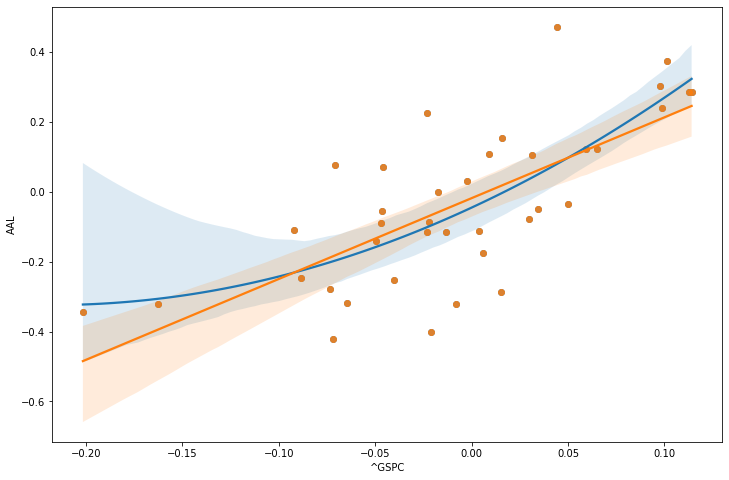

In [352]:
s2_convex = capm(state_2, asset, benchmark, rf, 2)
s2_convex.fit()
s2_convex.metrics(verbose=False)
s2_convex.plot(add_convex=True)

                AAL      ^GSPC       ^TNX
count     38.000000  38.000000  38.000000
mean      -0.036168  -0.007827   0.000444
std        0.229186   0.070731   0.000217
min       -0.420312  -0.201580   0.000113
25%       -0.228658  -0.046955   0.000181
50%       -0.065874  -0.010614   0.000508
75%        0.118074   0.033575   0.000567
max        0.472717   0.114097   0.000763
skewness   0.262253  -0.392092  -0.408688
kurtosis  -0.671071   0.614281  -1.133793


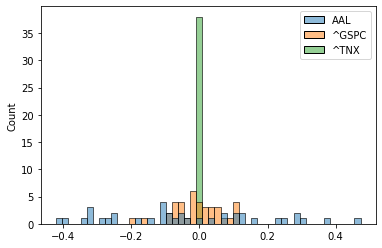

In [353]:
data_stats(state_2)

## Does the model make a difference? YES, if you are using conditional volatility.

In [354]:
# aggregate the convex model params into a single dataframe
s0 = s0_convex.params()
s1 = s1_convex.params()
s2 = s2_convex.params()

params = pd.DataFrame([s0, s1, s2])
params.columns = ['alpha', 'beta', 'gamma']
params_dict = params.to_dict()
params_dict


{'alpha': {0: -0.01666202970765862,
  1: 0.003100488906586625,
  2: -0.045099324468873186},
 'beta': {0: 1.834766542534855, 1: 1.5299322193138403, 2: 2.559721749421808},
 'gamma': {0: 8.740578086110308, 1: -2.9599667008370574, 2: 5.872505411600309}}

In [355]:
# join log_returns, prarms and hidden states to create a dataframe
er_df = pd.concat([log_returns, hmm_data], axis=1)

er_df['alpha'] = er_df['hidden_states'].map(params_dict['alpha'])
er_df['beta'] = er_df['hidden_states'].map(params_dict['beta'])
er_df['gamma'] = er_df['hidden_states'].map(params_dict['gamma'])

In [356]:
# implied returns 
er_df['convex_implied'] = er_df.alpha + er_df.beta * er_df[asset] + er_df.gamma * (er_df.volatility/100) ** 2
er_df['linear_implied'] = er_df.alpha + er_df.beta * er_df[asset] 


# difference between implied convex and linear returns
er_df['difference'] = er_df['linear_implied'] - er_df['convex_implied']

# make all columsn numeric
er_df[['alpha', 'beta', 'gamma', 'convex_implied', 'linear_implied', 'difference']] = er_df[['alpha', 'beta', 'gamma', 'convex_implied', 'linear_implied', 'difference']].apply(pd.to_numeric)
er_df.dtypes

AAL                      float64
^GSPC                    float64
^TNX                     float64
date              datetime64[ns]
volatility                object
hidden_states             object
state_1                  float64
state_2                  float64
state_3                  float64
alpha                    float64
beta                     float64
gamma                    float64
convex_implied           float64
linear_implied           float64
difference               float64
dtype: object

the states are ranged 0-2 mapping to state 1-3

In [357]:
er_df

,AAL,^GSPC,^TNX,date,volatility,hidden_states,state_1,state_2,state_3,alpha,beta,gamma,convex_implied,linear_implied,difference
2005-10-03,0.052839,-0.027986,0.000839,2005-10-03,0.014955,1,1.200297e-34,1.000000,6.041884e-97,0.003100,1.529932,-2.959967,0.083940,0.083940,6.619930e-08
2005-10-10,0.005403,-0.008696,0.000864,2005-10-10,0.020272,1,5.371620e-04,0.999463,1.908723e-07,0.003100,1.529932,-2.959967,0.011367,0.011367,1.216373e-07
2005-10-17,-0.014018,-0.006744,0.000844,2005-10-17,0.018787,1,5.068285e-04,0.999493,1.190217e-07,0.003100,1.529932,-2.959967,-0.018346,-0.018346,1.044753e-07
2005-10-24,0.084656,0.014951,0.000878,2005-10-24,0.017366,1,3.857702e-04,0.999614,9.101987e-08,0.003100,1.529932,-2.959967,0.132618,0.132618,8.926850e-08
2005-10-31,0.186497,0.017074,0.000896,2005-10-31,0.016829,1,3.306198e-04,0.999669,8.373777e-08,0.003100,1.529932,-2.959967,0.288428,0.288428,8.383400e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,0.002191,0.041184,0.000508,2022-07-25,0.031107,0,9.999366e-01,0.000063,3.282386e-08,-0.016662,1.834767,8.740578,-0.012642,-0.012643,-8.457971e-07
2022-08-01,0.072439,0.003055,0.000546,2022-08-01,0.033041,0,9.999519e-01,0.000048,1.293924e-07,-0.016662,1.834767,8.740578,0.116248,0.116247,-9.542235e-07
2022-08-08,0.034015,0.031492,0.000548,2022-08-08,0.028554,0,9.989467e-01,0.001053,6.525634e-08,-0.016662,1.834767,8.740578,0.045748,0.045747,-7.126301e-07
2022-08-15,-0.073452,-0.012720,0.000575,2022-08-15,0.028668,0,9.944327e-01,0.005566,8.200381e-07,-0.016662,1.834767,8.740578,-0.151429,-0.151430,-7.183338e-07


               gamma
count     881.000000
mean        0.382661
std         5.184136
min        -2.959967
25%        -2.959967
50%        -2.959967
75%         8.740578
max         8.740578
skewness    0.926430
kurtosis   -1.109238


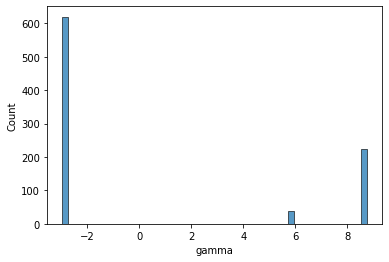

In [358]:
data_stats(er_df.gamma)

<AxesSubplot:>

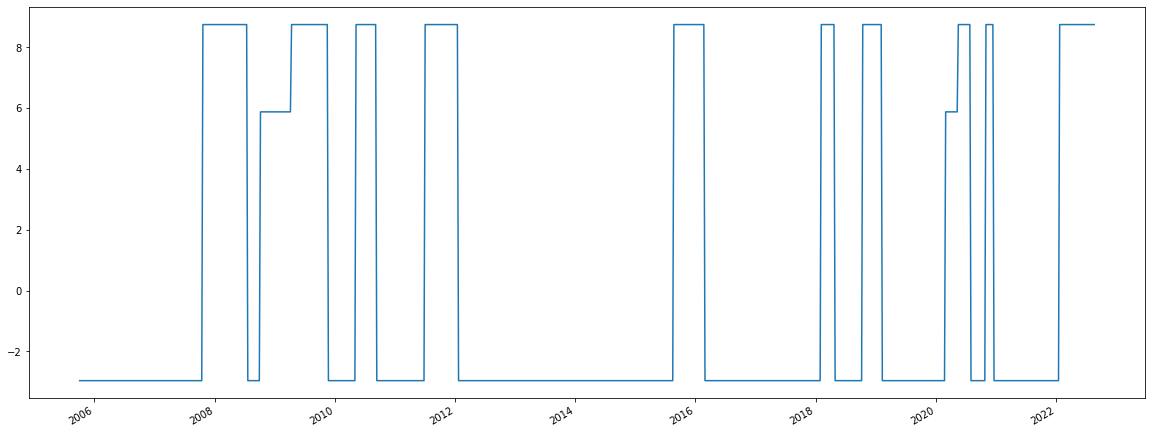

In [359]:
(er_df.gamma).plot(figsize = (20,8))

            difference
count     8.810000e+02
mean     -2.723968e-07
std       7.665171e-07
min      -7.188881e-06
25%      -5.208021e-07
50%       5.859009e-08
75%       9.338927e-08
max       2.709169e-07
skewness  0.000000e+00
kurtosis  2.064349e+01


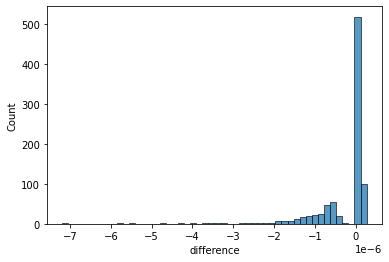

In [360]:
data_stats(er_df.difference)

<AxesSubplot:>

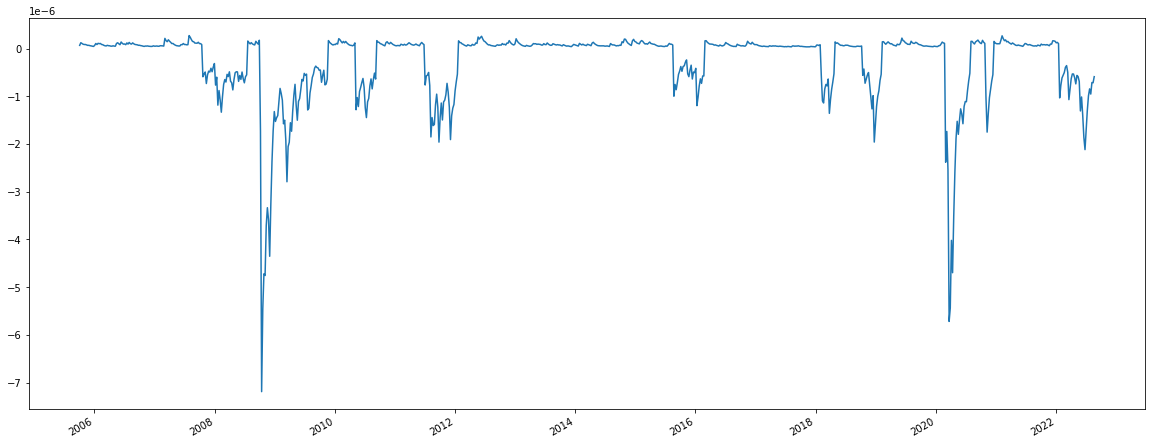

In [361]:
er_df.difference.plot(figsize=(20,8))

<AxesSubplot:xlabel='Date'>

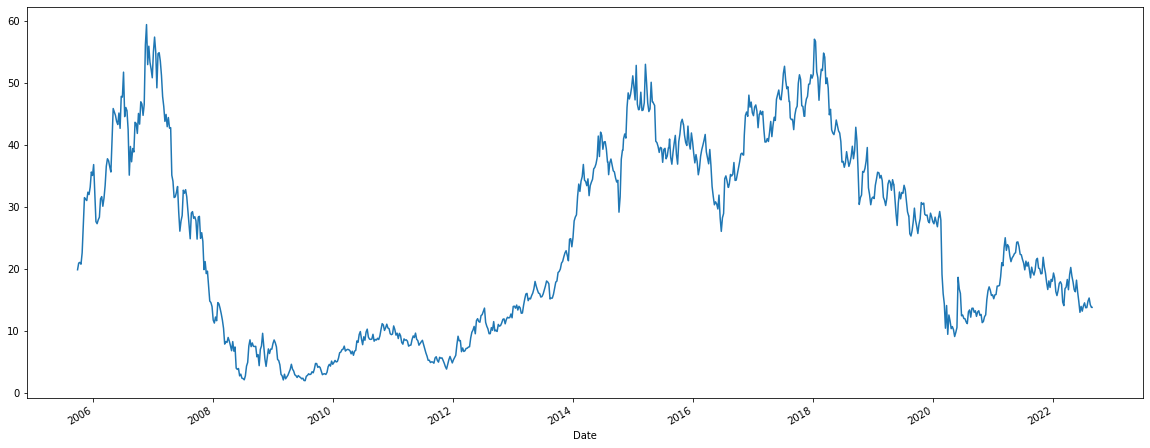

In [362]:
data[asset].plot(figsize=(20,8))

**CAPM would have understated the valuation of the asset since it does not adjust for the volatility of the market.** So as the market becomes way overpriced or volatile, investors should be compensated with higher required return for taking the risk, the revert to the long term averge will inevitably occur just like how asset bubbles burst.   
https://www.investopedia.com/terms/b/bubble-theory.asp#:~:text=Bubbles%20and%20Efficient%20Markets&text=The%20more%20volatile%20an%20asset,wealth%20creation%20that%20they%20present. 

In [363]:
# are they different? hypothesis testing
stats.ttest_1samp(er_df.difference, 0)

Ttest_1sampResult(statistic=-10.547952342379858, pvalue=1.4147013179304761e-24)

In [364]:
stats.ttest_ind(er_df.linear_implied, er_df.convex_implied)

Ttest_indResult(statistic=-3.04293682459824e-05, pvalue=0.9999757243253793)

<AxesSubplot:xlabel='Date'>

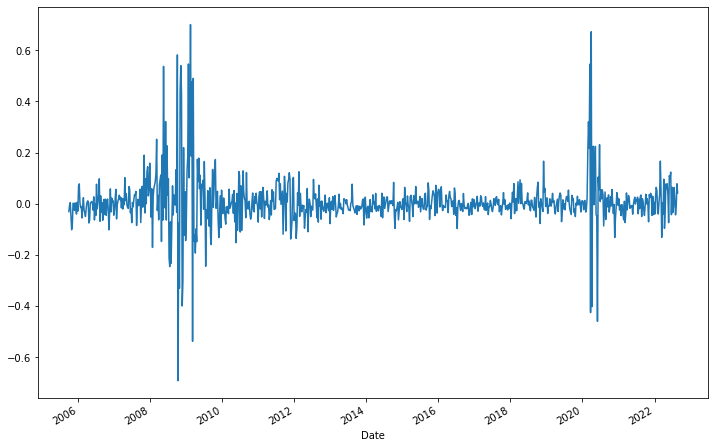

In [365]:
linear_abnormal_returns = log_returns[asset].subtract(er_df.linear_implied, axis=0)
linear_abnormal_returns.plot(figsize=(12,8))

                   0
count     881.000000
mean        0.006473
std         0.096298
min        -0.692208
25%        -0.025394
50%        -0.000719
75%         0.028681
max         0.700669
skewness    1.321519
kurtosis   18.448975


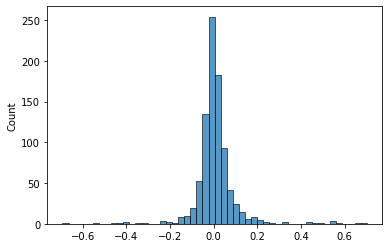

In [366]:
data_stats(linear_abnormal_returns)

<AxesSubplot:xlabel='Date'>

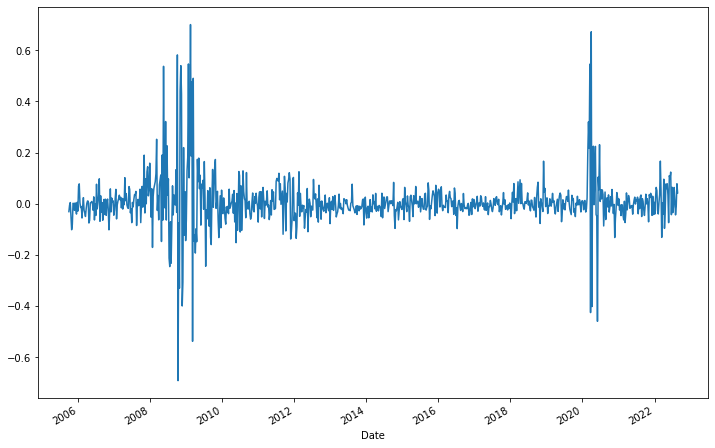

In [367]:
convex_abnormal_returns = log_returns[asset].subtract(er_df.convex_implied, axis=0)
convex_abnormal_returns.plot(figsize=(12,8))

                   0
count     881.000000
mean        0.006472
std         0.096298
min        -0.692216
25%        -0.025394
50%        -0.000719
75%         0.028680
max         0.700667
skewness    1.321460
kurtosis   18.449018


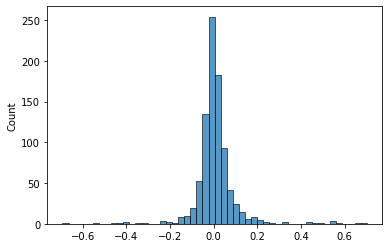

In [368]:
data_stats(convex_abnormal_returns)

<AxesSubplot:xlabel='Date'>

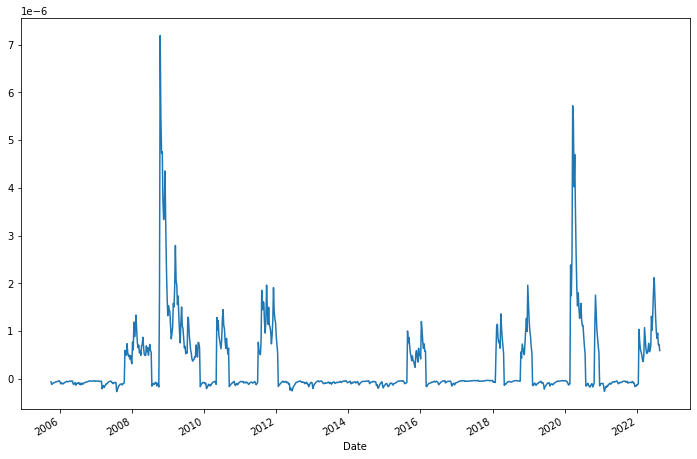

In [369]:
abrt_diff = linear_abnormal_returns-convex_abnormal_returns
abrt_diff.plot(figsize=(12,8))

                     0
count     8.810000e+02
mean      2.723968e-07
std       7.665171e-07
min      -2.709169e-07
25%      -9.338927e-08
50%      -5.859009e-08
75%       5.208021e-07
max       7.188881e-06
skewness  0.000000e+00
kurtosis  2.064349e+01


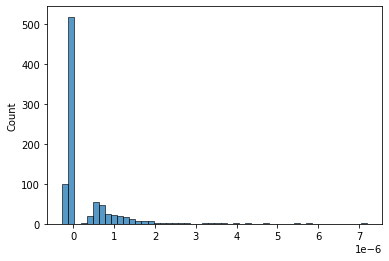

In [370]:
data_stats(abrt_diff)

## Refrences

https://research.macrosynergy.com/equity-convexity-and-gamma-strategies/#:~:text=Equity%20convexity%20means%20that%20a,a%20measure%20of%20that%20convexity.

https://quant.stackexchange.com/questions/31439/what-is-the-difference-between-conditional-volatility-and-realized-volatility

https://quant.stackexchange.com/questions/64096/realized-variance-realized-volatility